                                            Workshop 6: Annalaura Lerede, Valentina Giunchiglia and Dragos Gruia

# Introduction to Machine Learning


The aim of this workshop is to introduce you to the fundamental concepts of supervised Machine Learning. From the previous workshop, you should remember that supervised machine learning is a type of machine learning where the modls are trained on **labelled data**. For example, a model can be trained on a set of brain images of patients labelled as having Parkinson's or being healthy, from this data the model will learn how to predict the right clinical status of unseen images. 

As mentioned in Day 7, upervised learning can be further split into:
- *Classification*: classification algorithms are used to predict a **categorical output label**, such as Alzheimer vs healthy, Malign vs Benign, Female vs Male... Both binary and multi-label (more than two classes) classification can be computed. Commonly used supervised classification algorithms are: support vector machines, random forest, and logistic regression.
- *Regression*: regression algorithms attempt to predict a **continous output variable**, such as age, test scores, years of survival... Commonly used regression algorithms are lasso regression, decision trees, multivariate and simple linear regression.

In the workshop of today, we will go through an example of supervised and unsupervised machine learning algorithms, and we will implement both a regression and classification model. The aim of the workshop is to use machine learning to predict whether patients have Alzheimer's or are cognitive healthy based on their scores in different cognitive tests, and to predict their age using the same features. 

Throughout the workshop, we will use `sklearn`, which we introduced in Day 7. Let's start by importing the module in the notebook, together with other modules we might need. Like in previous workshops, we will change the display option for dataframe, in order to be able to visualize all columns when we print them.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# pre-processing imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# models imports
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# metrics imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)

Great! Let's import the data in a dataframe and check them out.

In [6]:
data = pd.read_csv("Data/Day6_data.csv")
data.head()

,PatientID,AGE,PTGENDER,PTEDUCAT,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,LDELTOTAL,TRABSCOR,FAQ,ICV,DX,mPACCdigit,mPACCtrailsB,Fusiform,Hippocampus,MidTemp,Ventricles,has_converted
0,83254,65.7,Male,10,0.3,9.33,1.12,2.0,30.0,48.0,3.0,3.0,9.0,81.0,0.0,1705524.0,CN,1.147870,-4.244279,17517.0,6547.0,20483.0,25676.0,False
1,11672,75.5,Male,20,3.5,13.84,15.24,2.0,21.0,41.0,5.0,4.0,5.0,71.0,3.0,1645224.0,Dementia,-0.579340,-2.690822,15709.0,4437.0,21476.0,48666.0,False
2,56145,69.3,Male,17,4.6,19.41,34.74,9.0,23.0,20.0,1.0,4.0,0.0,157.0,24.0,1687884.0,Dementia,-17.571771,-4.085680,11179.0,6282.0,15910.0,44451.0,False
3,61453,85.1,Female,13,2.9,22.36,11.87,3.0,24.0,16.0,2.0,6.0,6.0,153.0,1.0,1827863.0,Dementia,-18.068705,-12.656801,15341.0,3545.0,18243.0,73245.0,False
4,163073,79.2,Male,18,0.2,7.10,5.15,2.0,30.0,37.0,5.0,1.0,16.0,94.0,0.0,1715167.0,CN,-3.064381,-3.771917,18393.0,8629.0,21401.0,40258.0,False


In [7]:
data.shape

(5000, 24)

As you can see from the shape, the dataset has 24 different columns and 5000 rows. Each row corresponds to a different participant, and each column represent scores in different cognitive tests, demographics variables, the clinical status and some average imaging measures. 

More specifically, the following cognitive tests are included:

1. **Alzheimer’s Disease Assessment Scale (ADAS):** this is used to assess different cognitive functions. More in detail, ADASCog11 consists on 11 tasks that focus on memory, language, and praxis. ADASCog13 additionally evaluates the general functions of attention and concentration, planning and executive function.
2. **Functional Activities Questionnaire (FAQ):** this measures the ability of patients to complete daily life activities
3. **Trail Making Test (TRABSCOR):** this mainly assesses the patients’ visual scanning abilities, graphomotor speed, and executive functions
4. **Wechsler Memory Scale (LDELTOTAL)**: this evaluates patients’ memory and working memory.
3. **Rey Auditory Verbal Learning Test (RAVLT):** this assesses verbal memory.
3. **Clinical Dementia rating scale (CDRSB):** this measures the level of impairment of participants in 6 major domains, e.g memory, orientation, judgment and problem solving, community affairs, home and hobbies, and personal care [5].
4. **MiniMental State Exam (MMSE):** this evaluates the general functions of orientation, attention, memory, language and visualspatial skills
5. **Modified Preclinical Alzheimer Cognitive Composite (mPACC):** this evaluates episodic memory, timed executive function, and global cognition

In addition, the average volume measures in the Fusiform, Hippocampus, MidTemp and Ventricles are included, together with the intracranial volume (ICV). The volume measures of different brain regions are important in Alzheimer's because this disease is charaterized by **brain atrophy**, which means loss of brain volume.

The data we are going to use in this workshop are synthetic data, which means that they were synthetically generated appositely to complete this workshop in such a way that they resemble real patients data. We are not able to use the real data due to governance reasons around data sharing. Fun fact: we used machine learning to generate them and they were based on the real data. 

The first step we want to do is to separate the imaging features from the cognitive ones. We will start the analysis by working exclusively with the cognitive scores.

In [8]:
cognitive_features = ['CDRSB','ADAS11','ADAS13','TRABSCOR', 'RAVLT_immediate', 'ADASQ4',
                      'MMSE','RAVLT_learning','RAVLT_forgetting', 'LDELTOTAL', 'FAQ',
                      'mPACCtrailsB', "mPACCdigit"]

imaging_features = ['ICV','Fusiform','Hippocampus','MidTemp','Ventricles']

In [9]:
print(len(cognitive_features))
print(len(imaging_features))

13
5


In total we have 13 cognitive features and 5 imaging features.

## Classification: Alzheimer's or cognitively healthy?

The first goal of this workshop is to build a machine learning classifier that can predict whether the participants are **cognitively normal** or are affected by **dementia**. We expect, therefore, to have two labels and do binary classification.

When running classification algorithms, one of the first steps that should be completed is checking which one are the classes that should be predicted, how many classes there are and whether there is **class imbalance**. A class imbalance is generated when there is an unequal distribution of classes in the dataset,  meaning that there are more samples of one class compared to others. The **majority class** is defined as the class with most of the samples, and the **minority class** is the class with the smallest number. **Class imbalance** can be really problematic in ML, and can lead to poor performance if not dealt with. The reason of the poor performance is that when most of the samples are from one class, the ML model will be mainly trained on how to recognise one class and will tend to classify most of the data as belonging to the majority class (e.g. class with the highest number of samples). If the class imbalance is not identified at the beginning, the interpretation of the results can be misleading! Imagine the case in which you have 100 samples, and 90 are from class 1 and 10 from class 2. If the model predicts everything as class 1, the final accuracy (e.g. number of correctly classified samples) will appear to be very high: 90% correct!! However, in this case, the high performance doesn't correlate with a meaninful learning if the model and it just highlights how poorly the model performs. This also highlight how different metrics are accurate in different context and that some thought should be put into choosing the right metrics for the considered task.

Class imbalance should in general be avoided. However, this is not always possible. If present, it can be addressed in different ways:

1. **Down-sampling of the majority class:** randomly removing observations from the majority class. This is not the best approach, especially when the sample size is small.
2. **Over-sampling of the minority class**: randomly create copies of the minority class, or generate syntethic data that resemble the minority class samples in order to increase their number. 
3. **Algorithms penalization:** add a weight during the training of the model which specifies of how much more the model should be penalized if it predicts incorrectly the class of samples from the minority class.
4. **Ensamble of classifiers:** train N classifiers, each with the whole sample for the minority class and a sub-sample of the majority class as big as the minority class. Then predict unseen data using all N classifiers and take as final prediction the most voted class across classifiers. This way we transform an unbalenced classification problem into N balanced classification problems.

Of course, apart from these four approaches, it is always useful to use a metric of performance that is robust against class imbalance. For example, instead of reporting the general accuracy (e.g. the number of correctly classified samples), it is possible to report the number of false positives and false negatives. This will give a better overview on whether the model is actually predicting something, or just assigning the label of the majority class to all samples.

Let's double check that we actually dealing with a binary classification, and if there is class imbalance in our dataset.

In [10]:
data['DX'].value_counts(normalize=True)

CN          0.589
Dementia    0.411
Name: DX, dtype: float64

As you can see from the data, we have two labels: CN that corresponds to cognitively normal, and Dementia that describes patients affected by Alzheimer's. You can also notice that we have a slight class imbalance! Only 41% of the samples in the datatset are classified as having dementia, compared to 59% who are healthy controls. This might create issues in the downstream analysis. We will try to run the analysis both without (first) and with (later) addressing the class imbalance, and then we will compare the results.

Now that we know what our labels are, we can move forward and prepare the data for the machine learning model. The model takes as input an X and Y dataset, where X corresponds to the features used for the training (in this case the cognitive features) and Y to the label. The Y label cannot be categorical and needs to be converted to a **boolean** (True vs False) or **integer** format. In general, ML models cannot be trained on categorical features, which have to be either integer encoded or one-hot-encoded before training the model. In this case, all out features are numerical, so we don't need to conduct that extra step of pre-processing.

**IMPORTANT**: in this case we have a Y, or label, because we are doing *supervised* machine learning. The label Y is not provided in case of *unsupervised* machine learning.

In [11]:
X = data[cognitive_features]
y = (data['DX']!='CN')
X.head()

,CDRSB,ADAS11,ADAS13,TRABSCOR,RAVLT_immediate,ADASQ4,MMSE,RAVLT_learning,RAVLT_forgetting,LDELTOTAL,FAQ,mPACCtrailsB,mPACCdigit
0,0.3,9.33,1.12,81.0,48.0,2.0,30.0,3.0,3.0,9.0,0.0,-4.244279,1.147870
1,3.5,13.84,15.24,71.0,41.0,2.0,21.0,5.0,4.0,5.0,3.0,-2.690822,-0.579340
2,4.6,19.41,34.74,157.0,20.0,9.0,23.0,1.0,4.0,0.0,24.0,-4.085680,-17.571771
3,2.9,22.36,11.87,153.0,16.0,3.0,24.0,2.0,6.0,6.0,1.0,-12.656801,-18.068705
4,0.2,7.10,5.15,94.0,37.0,2.0,30.0,5.0,1.0,16.0,0.0,-3.771917,-3.064381


In [12]:
y.head()

0    False
1     True
2     True
3     True
4    False
Name: DX, dtype: bool

In [13]:
print(X.shape)
print(y.shape)

(5000, 13)
(5000,)


As you can see, our Y label is now boolean, where *True* corresponds to Dementia, and *False* to cognitively normal. In addition, our X dataset has 13 features (which are the cognitive scores), instead the Y data are one dimensional, because they correspond to a unique label.


Great! Now that we have our X and Y, we can start preparing the **train** and **test** set. As mentioned in the lecture this morning, when you train ML models, you always have to split the dataset into **train** and **test** sets. The aim of the splitting is to verify how the model performs on **unseen** data, meaning data that were not used for the training. The reason why this is important is that if the model performs very well on the data used for the training, and it doesn't generalise well on separate data, then it means that the model is simply **overfitted**. **Overfitting** occurs when the model performs very well on the training data, but does not perform well on separate data. This happens when the model learns the training data *too well*. Having an overfitted model is not useful, because it means that it cannot be used for any other data apart from those used for the training. It also suggests that it might be capturing and learning some of the noise in the data, instead of meaningfull patterns and characteristics. Overfitting tends to happen when you train the model using a high number of features or when you choose a model with too many degrees of freedom (e.g. when you try to fit a third-degree polynomial to linear data. When there are too many features, the model struggles to identify patterns that are generalisable. 

Of course, overfitting is not the only issue. If the model performs poorly on the training set as well as on the testing set, then it means that it is **underfitted**. Underfitting generally happens when there are not enough samples in the training set for the model to really learn from them or when we don't allow for enough training iterations for the model to learn.

Figure from [here](https://docs.aws.amazon.com/machine-learning/latest/dg/model-fit-underfitting-vs-overfitting.html)
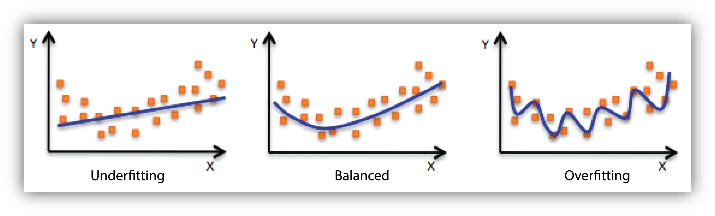

Separation into train and test set is a good way to check whether the model is overfitted. In addition, in order to avoid underfitting, you have to carefully decide what percentage of your data will be in the train vs test set. The more samples you have in the training set, the less likely it is for your model to be underfitted. However, at the same time, you don't want to have a really small test set, otherwise you won't be able to properly judge whether the model performs well on unseed data. Finding a balance between the number of samples you need in the train and test set can be tricky, and it usually depends on how many samples you have in total and on the type of machine learning algorithm you use. For example, if you use neural networks, which are an example of deep learning algorithms, then you will need many more samples in the training set in order to obtain a model that performs well compared to when using simpler algorithms such as logistic regression.

A standard separation in machine learning is 75/25, with 75% of the data being in the train set and 25% in the test set. But again, **this is not a rule** and it really depends on your data, algorithm and task.

*sklearn* provides ready to use functions to split the data into train and test set, such as `train_test_split`. You can check more detailed documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). The function has a few important arguments. First, it takes as input the data split into X and Y, and the desired size of test set in percentage (`test_size` argument). In addition, when dividing in train and test sets, we want to make sure to have the same proportion of classes in each set. To do that, we set the `stratify` paramenter equal to the class labels. Why is this important? Let's imagine the extreme case when we have a minority class that is really small, e.g. 5% of the total data. If we don't stratify the sets, we might end up with the whole minority class being in the training set or worse in the testing set. In the first case we wouldn't be able to assess the learning of the model because we wouldn't have minority samples in the test set, in the second case we wouldn't be able to learn how to distriguish minority class examples but we would get a fictitious high accuracy.

Finally, we provide a random state. The splitting into train and test is done randomly, which means that 25% of the samples are randomly added to the test set. By setting a random state, we are sure that regardless of how many times we rerun this line of code, the samples that will end up in the test set will always be the same. This is useful mainly when we want to create **reproducible** results (e.g. results that can be obtained again after running the entire code a second time).

**IMPORTANT**: the model should perform well regardless of the random state, and the way the data are split. If it doesn't, and instead it performs well only on a specific test set, then it means that the model is **not generalisable** and the results are not reliable.

The output of the function is a X and Y dataset both for the training and testing phases. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12, shuffle=True, stratify=y)

Let's check the shapes of the newly generated data.

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3750, 13)
(3750,)
(1250, 13)
(1250,)


As you can see from the shapes, the train set has now more or less 75% of the participants of the original dataset. Now, let's check whether the `stratify` function worked correctly and we actually have the same proportion of the two classes in the train and test set.

In [16]:
print(y_train.value_counts(normalize = True))
print('\n')
print(y_test.value_counts(normalize = True))

False    0.589067
True     0.410933
Name: DX, dtype: float64


False    0.5888
True     0.4112
Name: DX, dtype: float64


Great, the stratify function is working! Let's now have a quick look at the features and at what their distributions and ranges of variations are. If you remember from the day 2 workshop, having different ranges of variation can be problematic, and in ML specifically, it can decrease the performance of the models. This is why it is always important to check this. 

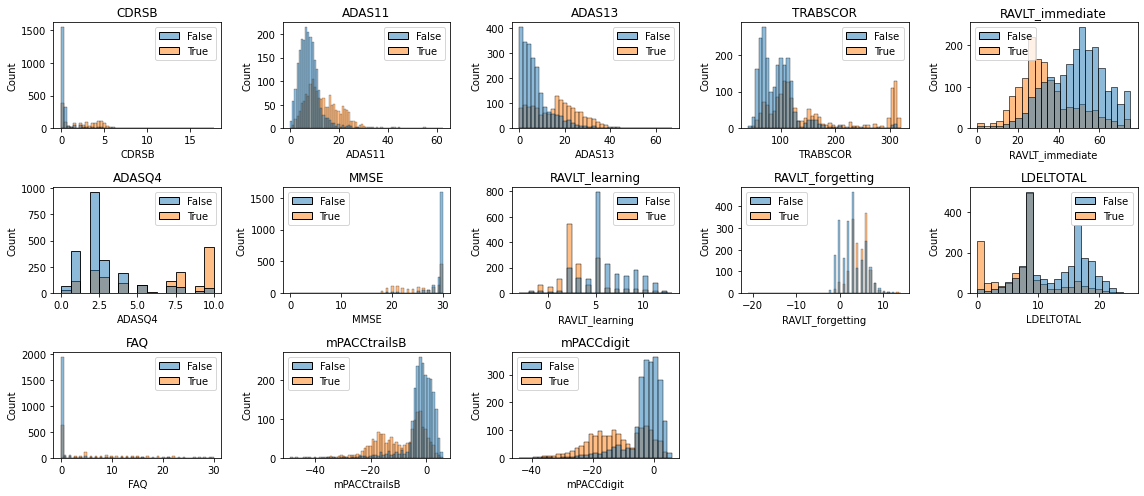

In [17]:
plt.figure(figsize = (16,7))
for i,col in enumerate(cognitive_features, start=1):
    plt.subplot(3, 5, i)
    sns.histplot(x = X_train[col], hue = y_train.values)
    plt.title(col)
plt.tight_layout()

------
## Code here

Try to create the plots for the test set and check how the distributions look

In [18]:
# Code here

--------

By looking at the distributions, you should notice that the cognitive features have different ranges of variation. For example, the MMSE score takes values between 0 and 20, instead the mPACCtrailsB has values that go below 0. This big difference will significantly affect the performance of the model if it isn't addressed. Now, the question is: why are we checking this only now and we didn't do it at the beginning, before splitting the data into train and test?

When doing machine learning, features should be scaled **only** after splitting the dataset into **train** and **test**, otherwise you risk to commit data leakage. **Data leakage** is the result of errors committed during the training of the model and preparation of the data, and is generated when accidentally information outside of the training set is used to train the model. For example, if information about the test set is, by mistake, provided to the model during training, then the test set is not fully **unseen** by the model and consequently the results are not reliable.

**Why can the scaling lead to data leakage?** If you remember from the day 2 lecture, to scale features you can either normalize them or standardise them, which means either turning their mean to 0 and standard deviation to 1, or scaling them between 0 and 1. If we scale the feature before splitting the dataset, then the samples of both the train and test will be used to do the normalization, or calculate the mean, which means that some of the information about the test set will be accidentally *leaked* to the model via the training set.

Today we will scale the features in order to have a mean of 0 and a standard deviation of 1. *sklearn* has a function that does it automatically called `StandardScaler()`. 

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Let's look at the distributions again

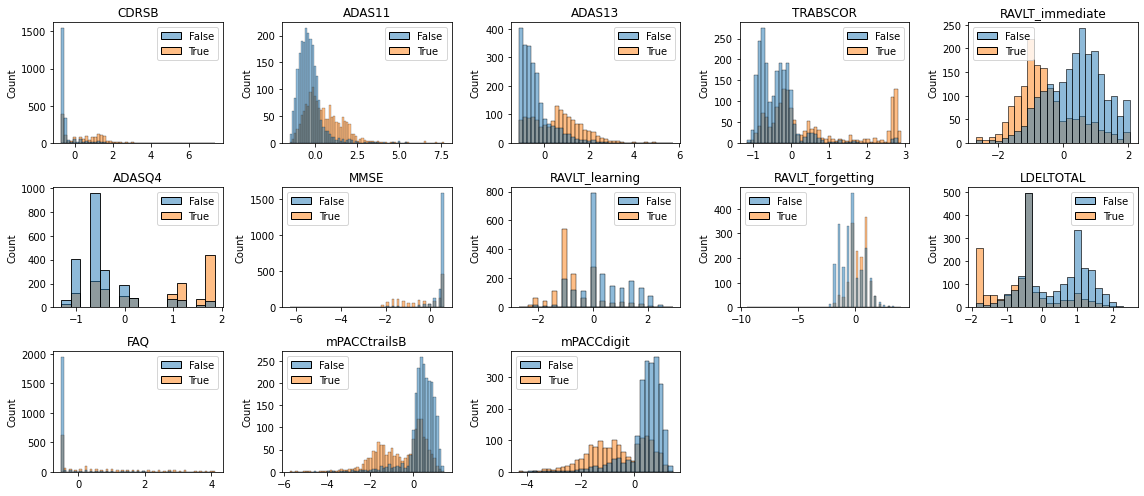

In [20]:
plt.figure(figsize = (16,7))
for i,col in enumerate(cognitive_features):
    plt.subplot(3, 5, i+1)
    sns.histplot(x = X_train[:,i], hue = y_train.values)
    plt.title(col)
plt.tight_layout()

Great! The ranges of variation look much better now. The data are ready to be used to train the model. To make the classification, today we will use a classifier called **Support Vector Machines** (SVM). The only thing you need to know about support vector machines is that they are commonly used classification algorithms. There is no need to understand them in details at this stage. You will learn more about different classifiers in M4, if you decide to do the computational stream. 

The good thing about using *sklearn* for machine learning is that it has a lot of flexibility, and it uses common coding structures regardless of the classifier you want to use. Indeed, the common steps completed to train a model for classification using sklearn are:
1. **Initialise the classifier** - in this case the classifier is called **SVC** and it corresponds to [**Support Vector Machines**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), but you could use many others such as [**Logistic Regression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [**Gradient Boosting**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), [**Random Forest**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)...
2. **Train the classifier** using the training data by providing as arguments the X and Y of the training set
3. **Predict** the labels (or classes) of the test and train set using the trained model

When you initialise the classifier you can provide a set of arguments depending on the type of classifier you are using. To check the full list of arguments available for `SVC`, you can print `?SVC`. In this case, we are reporting only three which are the *class_weight*, *random_state* and *kernel*. We already talked about the random state when using the function to split the train and test set. The class weight, instead, is a **penalisation** function that can be used to **penalise** the algorithm when you have class imbalance. If you remember from the beginning of the workshop, **algorithm penalisation** was one of the potential approaches to deal with class imbalance. At the moment, the class_weight is set equal to *None* which means that no penalisation is applied. We will rerun the analysis later on in the workshop with a penalisation function to check how the results change.

Finally, the kernel is an argument specific to **Suppport Vector Machines**. It doesn't really matter what the kernel does in terms of the math behind SVM. The only important thing you have to understand here is that SVM can take four major and different parameters as kernel (e.g. *rbf, linear, poly, and sigmoid*). Based on the kernel you select, the performance of the classifier will change. Now, the question is: **which kernel should you use?** There isn't a straightforward answer to this question. Indeed, the kernel is just an example of what in machine learning is defined as a **hyperparameter**. **Hyperparameters** are parameters external to the model, that need to be defined by the users, and that are dataset dependent. This means that the *right* kernel depends on the data you are using. One of the easiest approach to identify the optimal kernel, or the optimal hyperparameters in general, is to test all the different, and possible, values that the hyperparameter can have and choose the value that leads to the best performance of the model. This approach is called **Grid Search**. 

As you can imagine, this requires a lot of time and computational resources, mainly when you have a lot of hyperparameters to choose from and select. Just think it in this way: if you have 3 potential hyperparameters, each one with 4 potential values, then the total number of combinations you should test and train the models on are: 4 x 4 x 4 = **64 combinations!** There are of course better, and more complex, ways to identify the best parameters, but grid search is still really common. Due to time constraints, we will not be checking what is the best kernel in this case, or any of the other hyperparameters, but if you do ML, you always have to do that!

In [21]:
# Initialise the classifier

classifier = SVC(class_weight=None, random_state=10, kernel = "rbf")

# Train a Support Vector Machines classifier

classifier.fit(X_train, y_train)

# Get predictions for the training and testing sets

y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

Let's check the predictions on the test set

In [22]:
y_pred_test, len(y_pred_test)

(array([ True, False,  True, ..., False, False, False]), 1250)

As you can see, the model predicted true or False for all the 1250 samples of the test set. 

**How did our model perform?** 

An easy way to assess the performance of the model is by checking how many samples were predicted correctly. This measure of performance is called **accuracy** and it is calculated as follows:

$$ Accuracy = \frac{NumberCorrected}{TotalNumber}$$

*sklearn* has a ready to use function to measure accuracy called `accuracy_score`, that simply takes as input the predicted and true labels.

In [23]:
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Training set accuracy: ", accuracy_train)
print("Testing set accuracy: ", accuracy_test)

Training set accuracy:  0.8133333333333334
Testing set accuracy:  0.7824


As you can see from the accuracy scores, the accuracy on the training set is slightly higher, which might suggest that the model is *overfitted*. However, the performance on the test set is pretty good, because 78% of the samples are predicted correctly. This means that the model doesn't predict correclty only the data in the training set. Of course, the accuracy measure doesn't really tell us how many of the healthy and Alzheimer's patients were classified correctly. This is an important information to check, mainly because our dataset has class imbalance. To do that, we can just look at the confusion matrix. 

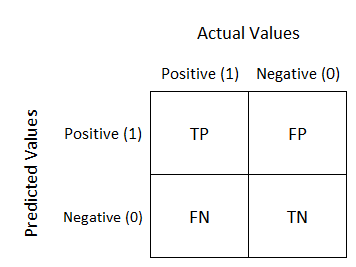

The confusion matrix provides information about the true positive (TP: number of correctly classified samples from the positive class), true negative (TN: number of correctly classified samples from the negative class), false positives (FP: number of misclassified samples from the positive class) and false negatives (FN: number of misclassified samples from the negative class).

Again, *sklearn* has an easy-to-use function that can create the confusion matrix for you.

In [24]:
confusion_mat = confusion_matrix(y_test, y_pred_test)
confusion_mat

array([[642,  94],
       [178, 336]])

Text(0.5, -3.5, 'Predicted Labels')

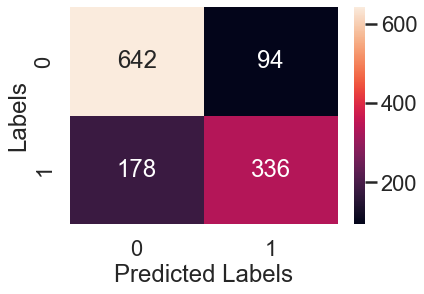

In [25]:
sns.set_theme("poster")
sns.heatmap(confusion_mat, annot = True, fmt='g')
plt.ylabel("Labels")
plt.xlabel("Predicted Labels")

-------

## Code here

Repeat the analysis, but change the type of kernel you used for SVC. Feel free to change any other of the hyperparameters of SVC (such as gamma and C). Train the classifier and check the performance. Did the results change? Which ones are the best parameters based on your data?


In [26]:
# Code here

-----------------

Looking at the confusion matrix we can see that the classifier doesn't predict everything as being the majority class (which is good!), but at the same time it tends to commit more mistakes when classifies the class 1, which corresponded to the minority class. To address this behaviour, when we have class imbalance, we can set the paramenter `class_weight` in the classifier initialisation to `balanced`. This tells the classifier to give more importance (in proportion) to errors made for samples of the minority class. The confusion matrix and accuracy are not the only possible performance metrics that you can use. More information on other available metrics can be accessed [here](https://scikit-learn.org/stable/modules/model_evaluation.html).

In [27]:
classifier = SVC(class_weight='balanced', random_state=10, kernel = "rbf")
classifier.fit(X_train, y_train)
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Training set accuracy: ", accuracy_train)
print("Testing set accuracy: ", accuracy_test)

Training set accuracy:  0.8090666666666667
Testing set accuracy:  0.7928


Text(0.5, -3.5, 'Predicted Labels')

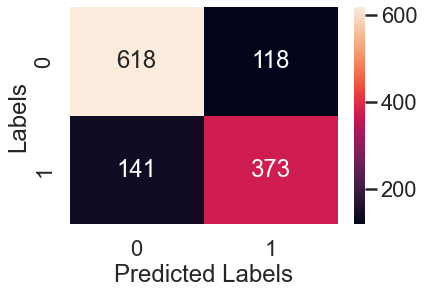

In [28]:
confusion_new = confusion_matrix(y_test, y_pred_test)
sns.heatmap(confusion_new, annot = True, fmt='g')
plt.ylabel("Labels")
plt.xlabel("Predicted Labels")

As you can see, after adding a weight to the model, the accuracy on the test set slightly increased and the number of inccorrectly classified samples for the minority class decreases. In addition, we can see a more distributed pattern in the errors. 

**IMPORTANT**: adding weights to the model will not necessarily always lead to improved accuracy, or performance. To understand why, let's think again about this example: if you have 80 samples out of 100 being of class 1, the performance of the model will be better if it predicts all samples as class 1. When we add a weight, however, we *prevent* the model from doing that, which means that the accuracy might decrease. However, it is better to have a model that doesn't predict everything as one class, even if the accuracy is lower. In these situations, other metrics of performance might be better suited.

### K-Fold cross validation

We made it! We managed to train a classifier with a good performance and predict Alzheimer's vs healthy using only cognitive scores. Now, however, we want to make a small step forwards by implementing and running **K-fold cross validation**. If you remember, at the beginning of the workshop, we split the dataset into train and test once, and then calculated the performance in the test set to prove that our model was not overfitted. However, a better approach is to run K-fold cross validation. With this approach, we compute the train/test split K times, and calculate the performance on K different test sets. The final model performance is then the mean performance across the K folds. By doing it like this, the results are even more reliable, because they are obtained after training and testing the model on different subsets of our dataset. This approach is also particularly useful when you have a small dataset and cannot afford to have many samples in the test set. By running k-fold cross validation, you can have potentially less samples in the test set, since you will test the model K times on different samples. A summary of K-fold cross validation is available in the figure, taken from [here](https://zitaoshen.rbind.io/project/machine_learning/machine-learning-101-cross-vaildation/)

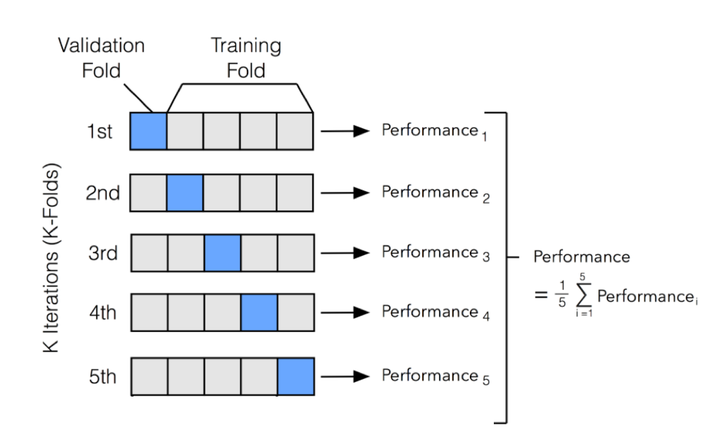

*sklearn* has ready to use functions to compute the k fold cross validation, called *StratifiedKFold*. The only important argument that needs to be specified is the number of splits, or K.

In [29]:
# Initiate k-fold splits

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
accuracies = []

# loop through the folds

for train_index, test_index in kfolds.split(X, y):
    
    # Obtain the different folds, or data subsets
    X_train, X_test = X.loc[train_index], X.loc[test_index]    
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    # Scale the datasets
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train the classifier
    classifier = SVC(class_weight='balanced', random_state=12)
    classifier.fit(X_train, y_train)
    y_pred_test = classifier.predict(X_test)
    
    # Get accurancy on current test fold
    accuracies.append(accuracy_score(y_test, y_pred_test))

In [30]:
accuracies

[0.815, 0.794, 0.788, 0.78, 0.788]

If you look at the accuracies, you can see that the values slightly change. This makes sense! There are always some patients that are harder or easier to predict than others!
Let's check what is the mean accuracy.

In [31]:
np.mean(accuracies)

0.7930000000000001

-------

## Code here

Repeat the analysis, but this time try using:
1. Different number of folds when doing K-Fold cross validation
2. Different type of classifier (You can select one of the classifiers mentioned above, or any other)


In [32]:
# Code here

--------

## Regression: Age of participants?

We wil now try to complete a regression task, and more specifically we will attempt to predict the age of participants based on their performance in the cognitive tests. All the steps we completed for the classification task need to be completed for the regression one, namely: 1) Splitting dataset into X and Y, train and test, 2) Scaling the features, 3) Training the model, and 4) Evaluating the performance. Let's do all these steps one by one. 

In [33]:
X = data[cognitive_features] 
y = np.round(data['AGE'])

In [34]:
y

0       66.0
1       76.0
2       69.0
3       85.0
4       79.0
        ... 
4995    78.0
4996    70.0
4997    70.0
4998    77.0
4999    78.0
Name: AGE, Length: 5000, dtype: float64

This time, the y is no longer binary (True vs False), but it is a continous variable (e.g. Age). Let's check the distirbution of age across the participants and what are the minimum, maximum and mean values. We also need to check whether there are missing values. If there are, then we cannot use that sample to train the model because the label is missing.

In [35]:
print(y.min())
print(y.max())
print(y.mean())
print(y.isnull().sum())

50.0
91.0
73.954
0


Text(0, 0.5, 'Count')

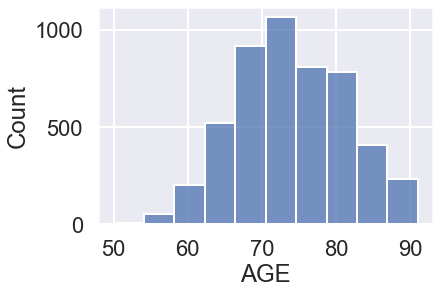

In [36]:
sns.histplot(y, bins=10)
plt.xlabel("AGE")
plt.ylabel("Count")

As you can see, the mean age is around 70, with the youngest patient being 50. This makes sense, because Alzheimer's is a neurodegenerative condition that tends to occur at older ages. 

Let's prepare the data for the training of the regression model. Today, we will use a really simple regression algorithm, which is linear regression. We talked about linear regression already in multiple previous workshops, so we won't explain it again here. 

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10, shuffle=True)

In [38]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The regression analysis in *sklearn* can be implemented in a really similar way to classification:
1. **Initialise the regression algorithm** - in this case we are using **LinearRegression**, but there are many others such as [**Lasso regression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), [**Support Vector Regression**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html), [**Decision Tree regressors**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html), [**Ridge Regression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) ...
2. **Train the model** using the training data by providing as arguments the X and Y of the training set
3. **Predict** the continous score of the test set using the trained model

In [39]:
# Intialise regression algorithm
lin_reg = LinearRegression()

# Train regression model
lin_reg.fit(X_train,y_train)

# Predict the score
y_pred = lin_reg.predict(X_test)

One of the biggest difference with classification is how you measure the performance of the model. This time, it doesn't make sense to use something like accuracy. Instead, two common measures of performance are the **mean squared error** and the **R2**. The **mean squared error (MSE)** can be defined as the average squared difference between the observed and the predicted values (we talked about this more in detail during day3). The bigger is the error, the worse is the prediction of the model.

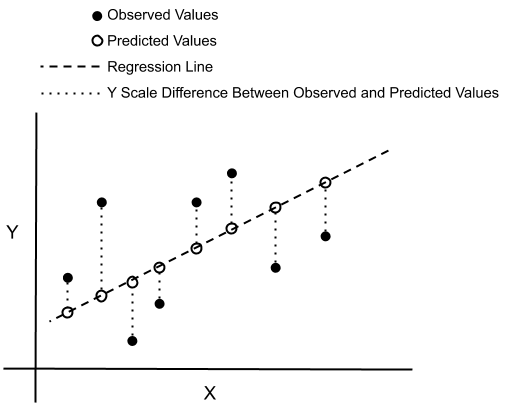

The **R2** instead corresponds to the **coefficient of determination** and it specifies the proportion of variance in the dependent variable that can be explained by the independent variable. An R2 of 1 corresponds to a perfect fit. In machine learning, the MSE is more commonly used to assess the performance of the model. Both these metrics can be easily calculated using the *sklearn* library by simply providing as input of the functions the predicted and observed scores.

In [40]:
# Print mean square error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Print coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 45.13
Coefficient of determination: 0.14


Usually, the MSE is easier to interpret as a measure of comparison across different models. But it is not easy to interpret when you want to understand how well the age of your participants was predicted. An easy way to check that is by plotting a scatterplot between the predicted and actual age, and by calculating the correlation coefficients. If the prediction is really good, we would expect a high correlation, and similar age ranges when looking at the scatterplots.

Text(0, 0.5, 'Age pred')

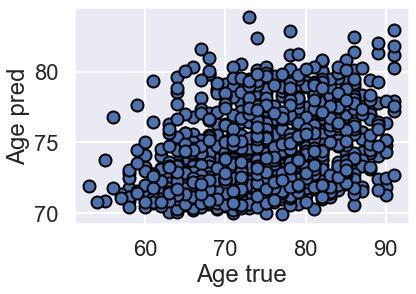

In [41]:
plt.scatter(y_test, y_pred, edgecolors='black')
plt.xlabel("Age true")
plt.ylabel("Age pred")

In [42]:
np.corrcoef(y_test, y_pred)

array([[1.        , 0.37097842],
       [0.37097842, 1.        ]])

The prediction of the model is definitely not perfect! But at least the model is not predicting the same age for all participants, and the correlation is still around 0.4 which is not bad. Maybe a different regression algorithm will perform better?

-------

## Code here

Repeat the analysis, but this time try a different regression algorithm. Compare the performance of the two models obtained by calculating the R1 and MSE. 


In [43]:
# Code here

------

# Challenge: predict Alzheimer's progression

In the workshop today, we used machine learning to predict whether a patient is cognitively healthy or has Alzheimer's based on their performance in cognitive tests using machine learning, and then used the same measures to predict the age of participants. In the challenge, you have to use imaging and cognitive measures to predict whether healthy particpants, or participants with MCI will convert to alzheimer's or not, and predict their performance in a cognitive score (ADAS), which is a good measure of Alzheimer's progression.  Concretely you have to do the following:

1. There are a lot of features in the imaging metrics. Apply dimensionality reduction or feature selection in order to prevent your model from being overfitted.
2. Use the imaging and cognitive features to predict whether patients will convert to Alzheimer's or not
3. Use the imaging and cognitive features to predict the ADAS score of participants

!! The data has a high class imbalance, make sure to address it using one of the methods explained in the lecture/workshop

**IMPORTANT**: Make sure to use the techniques we taught you in the lecture